# **CIS 520: Machine Learning**

## **Autoencoder**


- **Content Creator:** Shaozhe Lyu
- **Content Checkers:** Xiayan Ji
- **Acknowledgements:** [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)
- **Objectives:** In this worksheet, we use Pytorch to implement VAE, a variant of Autoencoder from scratch. 


## **Autograding and the PennGrader**


Enter your PennID (numbers not letters!) in the specified section.

In [1]:
%%capture
!pip install penngrader


In [2]:
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *

import dill
import base64

In [3]:
# For autograder only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


### Insert PennID here!

In [4]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 57931095 # YOUR PENN-ID GOES HERE AS AN INTEGER#

In [5]:
import penngrader.grader

grader = penngrader.grader.PennGrader(homework_id = 'CIS_5200_202230_HW_Autoencoder_WS', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 57931095

Make sure this correct or we will not be able to store your grade


In [6]:
# A helper function for grading utils
def grader_serialize(obj):        # A helper function
    '''Dill serializes Python object into a UTF-8 string'''
    byte_serialized = dill.dumps(obj, recurse = True)
    return base64.b64encode(byte_serialized).decode("utf-8")

## **VAE Introduction**


VAE is a variant of Autoencoder. It can generate new instances that look similar to the original training data (not exactly the same). The VAE implemented here uses a standard setup: a multivariate Normal distribution for the conditional distribution of the latent vectors given and input image ($q_{\phi}(z | x_i $) in the slides) and a multivariate Bernoulli distribution for the conditional distribution of images given the latent vector ($p_{\theta}(x | z)$ in the slides). Using a Bernoulli distribution, the reconstruction loss (negative log likelihood of a data point in the output distribution) reduces to the pixel-wise binary cross-entropy. See the [original VAE paper](https://arxiv.org/pdf/1312.6114.pdf), Appendix C.1 for details.

## **Load data**

In [7]:
import torch
import torchvision
import h5py
import numpy as np
import torchvision.transforms as transforms
from torchvision.models.detection.image_list import ImageList 
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.utils as vutils
torchvision.datasets.MNIST('.', download=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train

## **VAE network**

In [8]:
class VAE(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = torch.nn.Linear(784, 400)
    self.fc2a = torch.nn.Linear(400, 20)
    self.fc2b = torch.nn.Linear(400, 20)
    self.fc3 = torch.nn.Linear(20,400)
    self.fc4 = torch.nn.Linear(400,784)
    self.relu = torch.nn.ReLU()
    self.sig = torch.nn.Sigmoid()

  def forward(self, X):
    mu,sigma = self.encoder(X)
    x = self.reparameter(mu,sigma)
    x = self.decoder(x)
    return x,mu,sigma
  
  def encoder(self,x):
    x = self.relu(self.fc1(x))
    mu = self.fc2a(x)
    sigma = self.fc2b(x)
    return mu,sigma

  def decoder(self,x):
    x = self.relu(self.fc3(x))
    x = self.sig(self.fc4(x))
    return x
  
  def reparameter(self,mu,sigma):
    if torch.cuda.is_available():
      eps = torch.empty_like(sigma).normal_().cuda()
    else:
      eps = torch.empty_like(sigma).normal_()  
    
    new_eps = torch.mul(eps,torch.exp(0.5*sigma)) + mu
    return new_eps

## **VAE loss**
The loss function for training VAEs contains two parts:

1) A reconstruction error that pushes the reconstructed outputs to be close  to the inputs. 

2) A Kullback-Leibler (KL) divergence, which pushes the latent space to be a Gaussian distribution which we will sample from during inference. 
The VAE formulation is as follows: 

  $\log P(x)− KL[Q(z|x)||P(z|x)] = E_{z∼Q}[log P(x|z)] − KL[Q(z|x)||P(z|x)]$  


where $E_{z∼Q}[log P(x|z)]$ is the log-likelihood modeled by the decoder, and the KL term refers to Kullback-Leibler divergence between the posterior distribution Q(z|x) modeled by the encoder and the prior distribution P(z). In VAE, we assume P(z) is a normal distribution N(0, 1) and the encoder estimates a mean µ(x) and standard deviation σ(x) to approximate the posterior normal distribution Q, where Q(z|x) = Q(z|µ(x), σ(x))

In [9]:
class VAE_loss(torch.nn.Module):
  def __init__(self):
    super().__init__()  

  def forward(self,pred_x,x,mu,sigma):
    log_loss = self.log_loss(pred_x,x)
    KLD_loss = self.KLD_loss(mu,sigma)
    loss = log_loss + KLD_loss
    return  loss,log_loss,KLD_loss

  def log_loss(self,pred_x,x):
    # x = x.detach()
    bce = torch.nn.MSELoss(reduction='sum')
    # bce = torch.nn.BCELoss(reduction='sum')
    
    log_loss = bce(pred_x,x)
    return log_loss
  
  def KLD_loss(self,mu,sigma):
    sigma2 = torch.exp(sigma)
    mu2 = torch.pow(mu,2)
    kld_loss = -0.5*torch.sum(1+sigma-mu2-sigma2)
    return kld_loss

## **Train the model**

In [10]:
def curve_plt(epoch,train_loss,test_loss,name = ''):
  plt.figure(1)
  # plt.subplot(2,1,1)
  plt.gca()
  plt.plot(epoch,train_loss,color='r', linewidth=1, alpha=0.6,label='train'+name+'_loss')
  plt.plot(epoch,test_loss,color='b', linewidth=1, alpha=0.6,label='test'+name+'_loss')
  plt.xlabel('epoch')
  plt.ylabel(name+'loss')
  plt.legend()
  plt.show()

In [11]:
BATCH_SIZE = 128

train_mnist = torchvision.datasets.MNIST(root = '.',train = True,
                      transform=torchvision.transforms.Compose([
                          torchvision.transforms.ToTensor()]
                      ))
train_loader = torch.utils.data.DataLoader(dataset = train_mnist,batch_size = BATCH_SIZE,shuffle = True)
test_mnist = torchvision.datasets.MNIST(root = '.',
                    train = False,
                    transform=torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor()]
                    ))
test_loader = torch.utils.data.DataLoader(dataset = test_mnist,batch_size = BATCH_SIZE,shuffle = True)


In [12]:
def train(epoch):
  train_per_loss = 0
  train_per_log_loss = 0
  train_per_kld_loss = 0
  vae_network.train()
  for i,(train_x,train_y) in enumerate(train_loader):
    # inputs = torch.autograd.Variable(train_x.view(len(train_x),1,784)/255).cuda()
    inputs = torch.autograd.Variable(train_x.view(len(train_x),1,784)).cuda()
    label = torch.autograd.Variable(train_y).cuda()
    optimizer.zero_grad()
    output,mu,sigma = vae_network(inputs)
    loss,log_loss,KLD_loss = criterion(output,inputs,mu,sigma)
    loss.backward()
    optimizer.step()
    train_per_loss = train_per_loss + loss.item()
    train_per_log_loss = train_per_log_loss + log_loss.item()
    train_per_kld_loss = train_per_kld_loss + KLD_loss.item()
    if i%1000 == 999:
      print('%5d: Loss: %.3f,log_Loss: %.3f,klf_Loss: %.3f'%(i,loss.item(),log_loss.item(),KLD_loss.item()))
  return train_per_loss,train_per_log_loss,train_per_kld_loss

In [13]:
def test():
  test_per_loss = 0
  test_per_log_loss = 0
  test_per_kld_loss = 0
  vae_network.eval()
  with torch.no_grad():
    for i,(test_x,test_y) in enumerate(test_loader):
      # inputs = torch.autograd.Variable(test_x.view(len(test_x),1,784)/255).cuda()
      inputs = torch.autograd.Variable(test_x.view(len(test_x),1,784)).cuda()
      label = torch.autograd.Variable(test_y).cuda()
      output,mu,sigma = vae_network(inputs)
      loss,log_loss,KLD_loss = criterion(output,inputs,mu,sigma)
      test_per_loss = test_per_loss + loss.item()
      test_per_log_loss = test_per_log_loss + log_loss.item()
      test_per_kld_loss = test_per_kld_loss + KLD_loss.item()
      if i%1000 == 999:
        print('%5d: Loss: %.3f'%(i,loss.item()))
  return test_per_loss,test_per_log_loss,test_per_kld_loss

In [14]:
## fixed image
for i,(test_x,test_y) in enumerate(test_loader):
  inputs = torch.autograd.Variable(test_x.view(len(test_x),1,784)).cuda()
  break
fixed_input_36 = inputs[:36]
fixed_input_6 = inputs[:6]

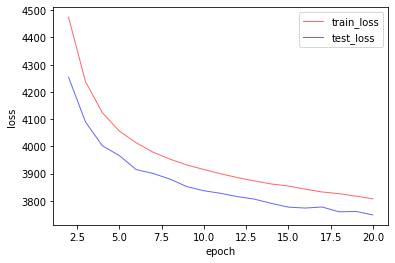

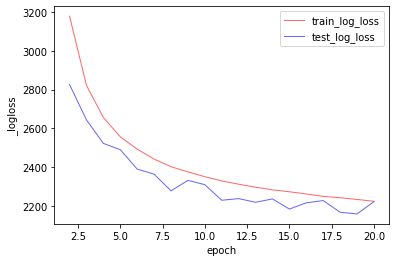

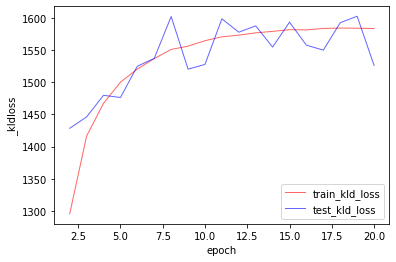

In [15]:
vae_network = VAE()
if torch.cuda.is_available():
  vae_network = vae_network.cuda()

criterion = VAE_loss()
optimizer = torch.optim.Adam(vae_network.parameters(),lr = 0.001,weight_decay=1e-5)
num_epochs = 20

# init list
train_loss = []
train_log_loss = []
train_kld_loss = []
test_loss = []
test_log_loss = []
test_kld_loss = []
epoch_set = []

fix_6 = torch.Tensor([])
for epoch in range(num_epochs):
  epoch_set.append(epoch+1)
  # train 
  train_per_loss,train_per_log_loss,train_per_kld_loss = train(epoch)
  train_loss.append(train_per_loss/len(train_loader))
  train_log_loss.append(train_per_log_loss/len(train_loader))
  train_kld_loss.append(train_per_kld_loss/len(train_loader))

  test_per_loss,test_per_log_loss,test_per_kld_loss = test()
  test_loss.append(test_per_loss/len(test_loader))
  test_log_loss.append(test_per_log_loss/len(test_loader))
  test_kld_loss.append(test_per_kld_loss/len(test_loader))

  if epoch %3 ==2:
    output,mu,sigma = vae_network(fixed_input_6)
    fix_6 = torch.cat((fix_6,output.cpu()),dim=0)

k = 1
curve_plt(epoch_set[k:],train_loss[k:],test_loss[k:],name = '')
curve_plt(epoch_set[k:],train_log_loss[k:],test_log_loss[k:],name = '_log')
curve_plt(epoch_set[k:],train_kld_loss[k:],test_kld_loss[k:],name = '_kld')


## **decode and plot**

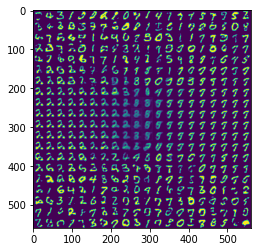

In [16]:
import numpy as np
total_img_size = 20 

mean_data = np.linspace(-3, 3, total_img_size)
std_data = np.linspace(-3, 3, total_img_size)
vae_network.eval()
img_size = 28
new_img = np.zeros((img_size*total_img_size,img_size*total_img_size))
for i, yi in enumerate(mean_data):
  for j, xi in enumerate(std_data):
    m = vae_network.decoder(torch.empty(1, 1, 20).normal_(mean = xi,std = yi**2).cuda())
    m_ij = m.reshape(1,1,28,28).squeeze(0).squeeze(0).cpu().detach()
    new_img[i*img_size:(i+1)*img_size,j*img_size:(j+1)*img_size] = m_ij
plt.imshow(new_img)

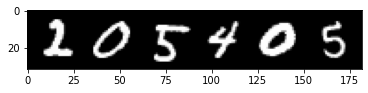

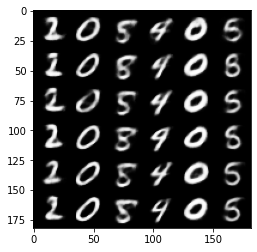

In [17]:
img = vutils.make_grid(fixed_input_6.reshape(-1,1,28,28),nrow = 6,normalize=True).cpu()
plt.imshow(img.permute(1,2,0).detach().numpy())
plt.show()
img = vutils.make_grid(fix_6.reshape(-1,1,28,28),nrow = 6,normalize=True).cpu()
plt.imshow(img.permute(1,2,0).detach().numpy())
plt.show()


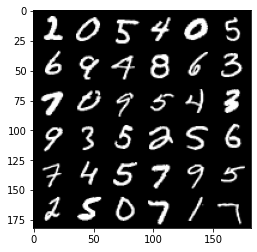

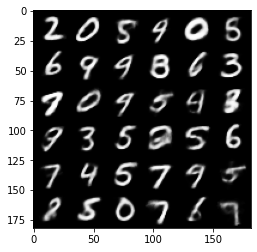

In [18]:
img = vutils.make_grid(fixed_input_36.reshape(-1,1,28,28),nrow = 6,normalize=True).cpu()
plt.imshow(img.permute(1,2,0).detach().numpy())
plt.show()
output,mu,sigma = vae_network(fixed_input_36)
img = vutils.make_grid(output.reshape(-1,1,28,28),nrow = 6,normalize=True).cpu()
plt.imshow(img.permute(1,2,0).detach().numpy())
plt.show()

## *Question*

<!-- What's the difference between normal Autoencoder and VAE? -->

In [19]:
#@markdown What's the difference between normal Autoencoder and VAE?
Q = 'Input is encoded in 2 vectors rather than 1' #@param {type:"string"}

In [20]:
grader.grade(test_case_id = 'autoencoder_compare', answer = Q)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.



## Submission

Please make sure to download your finished worksheet as .ipynb and again as .py, and submit both Autoencoder_WS.ipynb and Autoencoder_WS.py to Gradescope.
